In [1]:
import os, glob
import sys
import copy 
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow import keras
from scipy.ndimage import rotate
from skimage import exposure
from sklearn.metrics import confusion_matrix
from operator import add 
plt.set_cmap('gray')
%matplotlib inline
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = np.float
SEG_DTYPE = np.uint8


In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
masks_path = os.path.join('train','masks')
training_path = os.path.join('train','patients')

In [22]:
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

def dice(im1, im2):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [5]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):

        tumor_volume = None
        
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        
        image = preprocess_img_slc(dicom_image.pixel_array)
       
        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array
        
        image = np.multiply(image,np.clip(liver_mask,0,1))
        
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = cv2.imread(os.path.join(masks_path,'merged_livertumors', id_name+'.jpg'))
        
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        retval, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = mask // 255
        
        mask = mask[:, :, np.newaxis]
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
        for id_name in files_batch:

            _img, _mask = self.__load__(id_name)
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [6]:
image_size =  256
train_path = "train"
batch_size = 8
epochs = 50
## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):

    images.append(file)


## Validation Data Size
val_data_size = len(images)//5 # 20% validation Data
# factor = 0
valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]
print(len(train_ids))

16220


In [7]:
def preprocess_img_slc(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Set pixels with hounsfield value great than 1200, to zero.
    2- Clip all hounsfield values to the range [-100, 400]
    3- Apply Histogram Equalization
    """    
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)
    img_slc = normalize_image(img_slc)

    
    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = normalize_image(img_slc)
    return img_slc


In [8]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape,y.shape)

(8, 256, 256, 3) (8, 256, 256, 1)


0


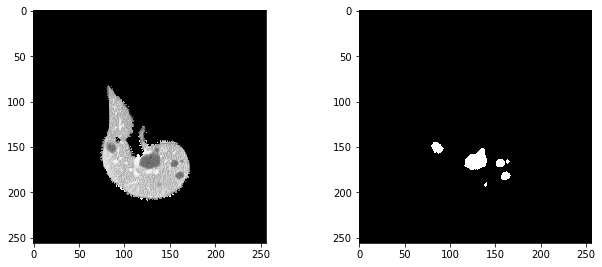

In [9]:
r = random.randint(0, len(x)-1)
r = 0
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [10]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [11]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [12]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [13]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=["acc", dice_coef])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_norm

In [12]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
# test_gen  = DataGenTest(train_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/50
2027/2027 [==============================]2027/2027 [==============================] - 849s 419ms/step - loss: 0.3623 - acc: 0.9933 - dice_coef: 0.6377 - val_loss: 0.7880 - val_acc: 0.9922 - val_dice_coef: 0.2120

Epoch 2/50
2027/2027 [==============================]2027/2027 [==============================] - 741s 365ms/step - loss: 0.2845 - acc: 0.9965 - dice_coef: 0.7155 - val_loss: 0.2720 - val_acc: 0.9959 - val_dice_coef: 0.7280

Epoch 3/50
2027/2027 [==============================]2027/2027 [==============================] - 739s 365ms/step - loss: 0.2535 - acc: 0.9969 - dice_coef: 0.7465 - val_loss: 0.4048 - val_acc: 0.9956 - val_dice_coef: 0.5952

Epoch 4/50
2027/2027 [==============================]2027/2027 [==============================] - 739s 365ms/step - loss: 0.2428 - acc: 0.9971 - dice_coef: 0.7572 - val_loss: 0.2370 - val_acc: 0.9968 - val_dice_coef: 0.7630

Epoch 5/50
2027/2027 [==============================]2027/2027 [==============================] - 73

In [16]:
# model.save('tumor_model_50epochs.h5')  # creates a HDF5 file 'my_model.h5'
# model.save_weights("tumor_weights_final_50epochs.h5")
model = keras.models.load_model(os.path.join('Working Models','tumor_model_50epochs.h5'),compile=False)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
# model.summary()

# del model

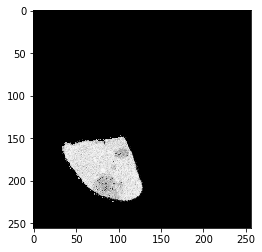

In [17]:
x, y = valid_gen.__getitem__(2)
result = model.predict(x)

# result = result > 0.5

imshow(x[1])


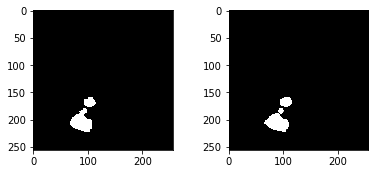

In [18]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


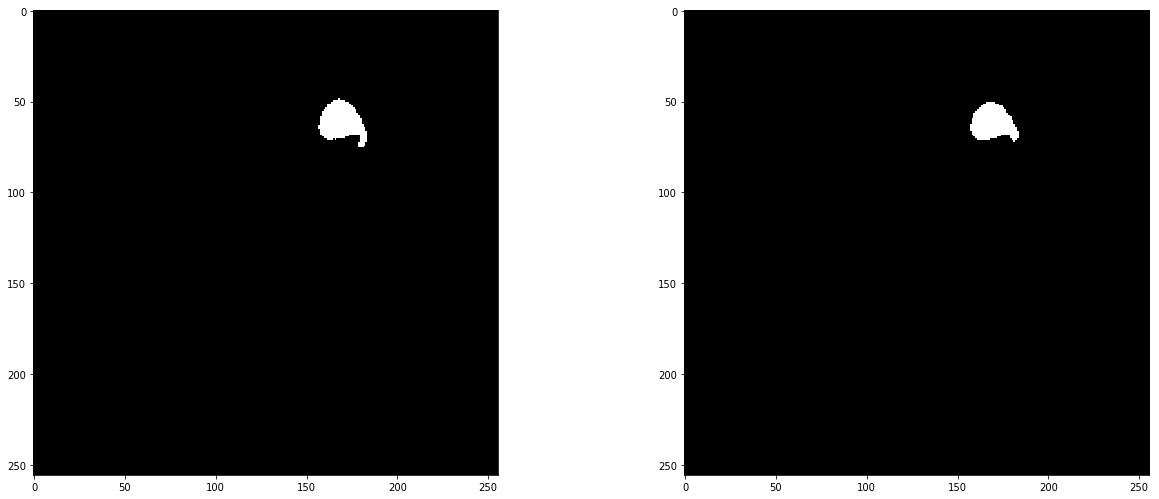

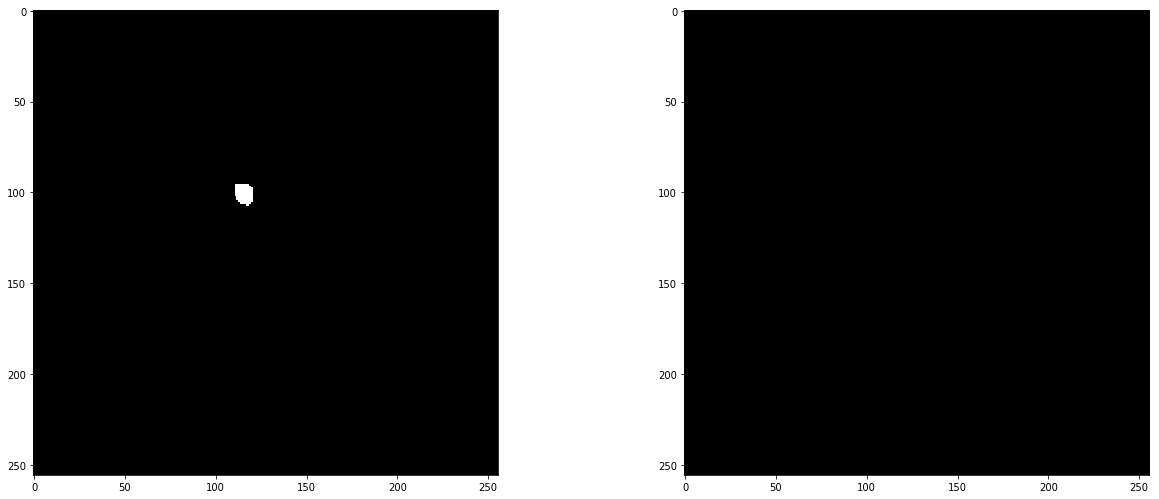

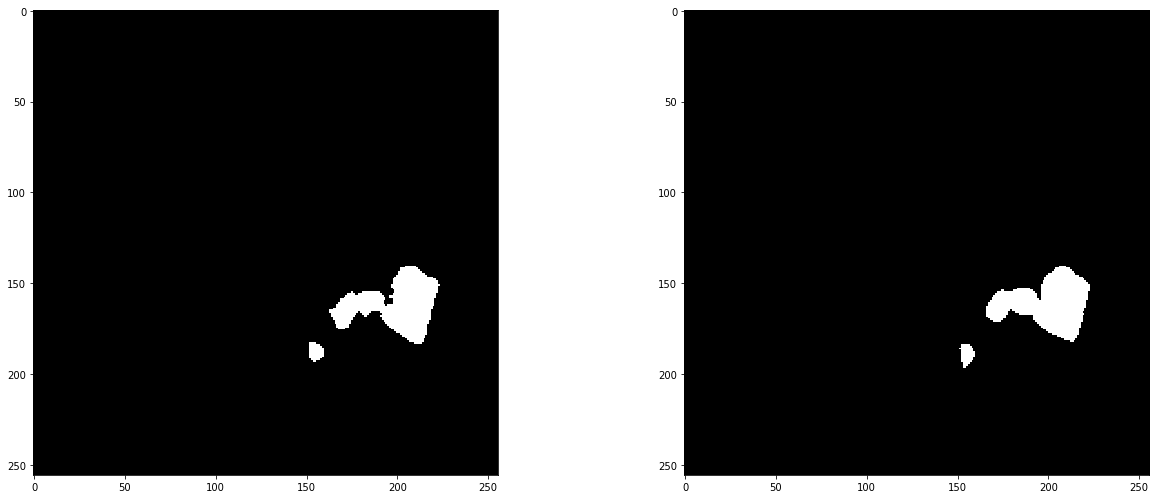

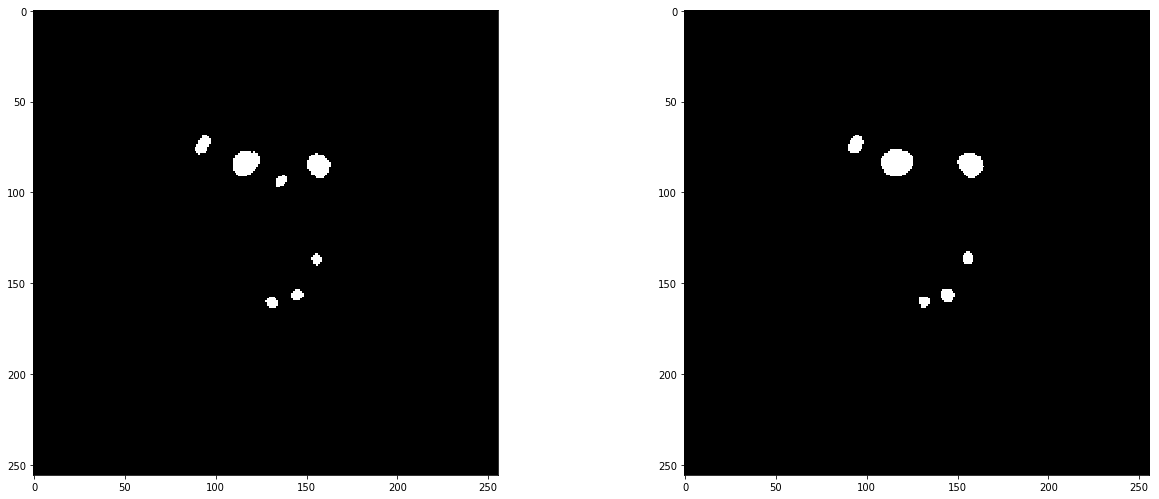

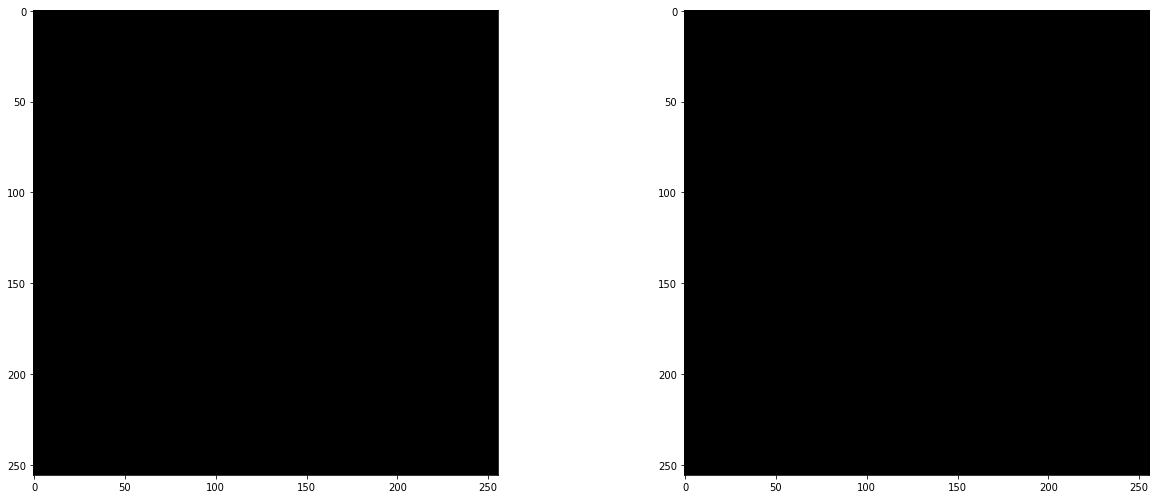

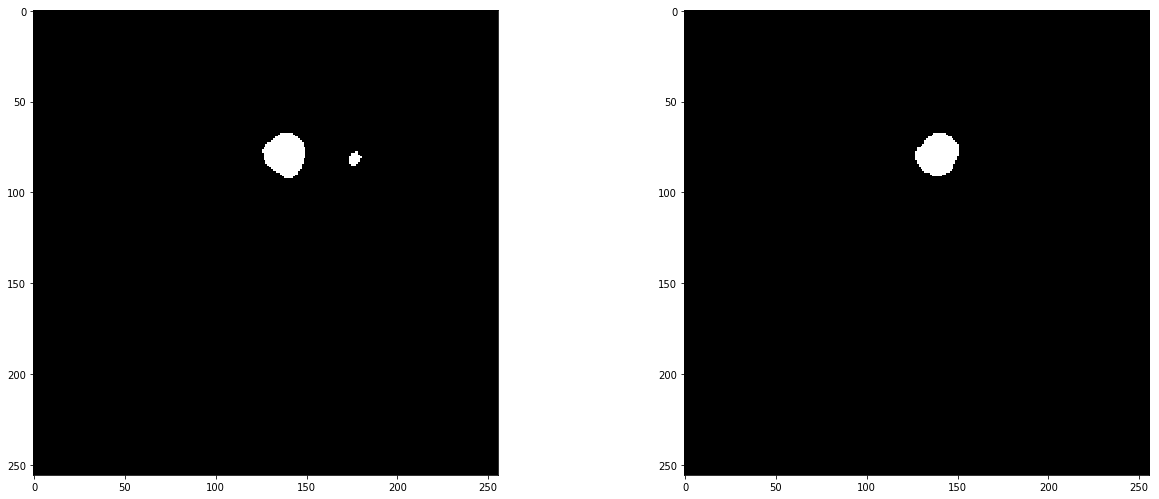

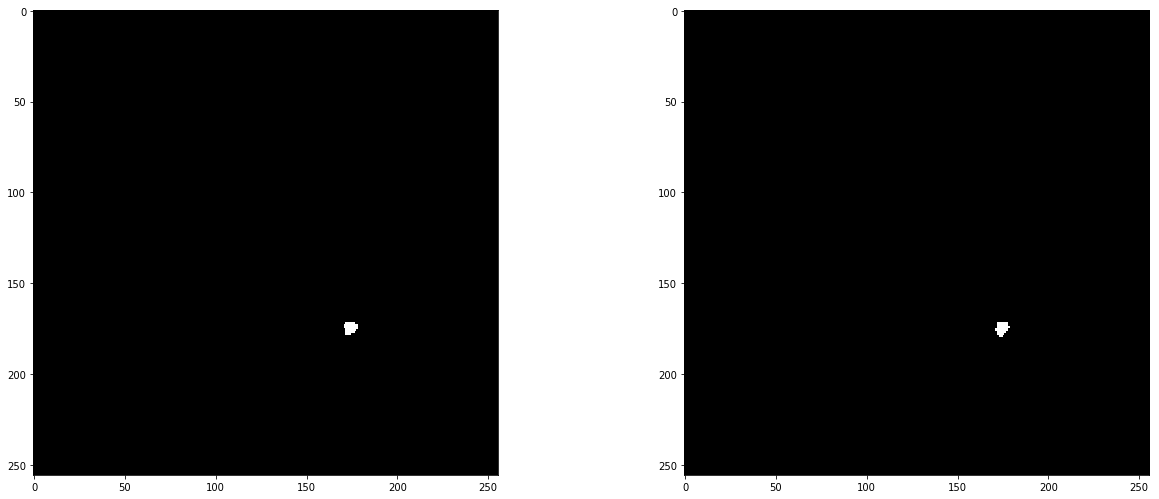

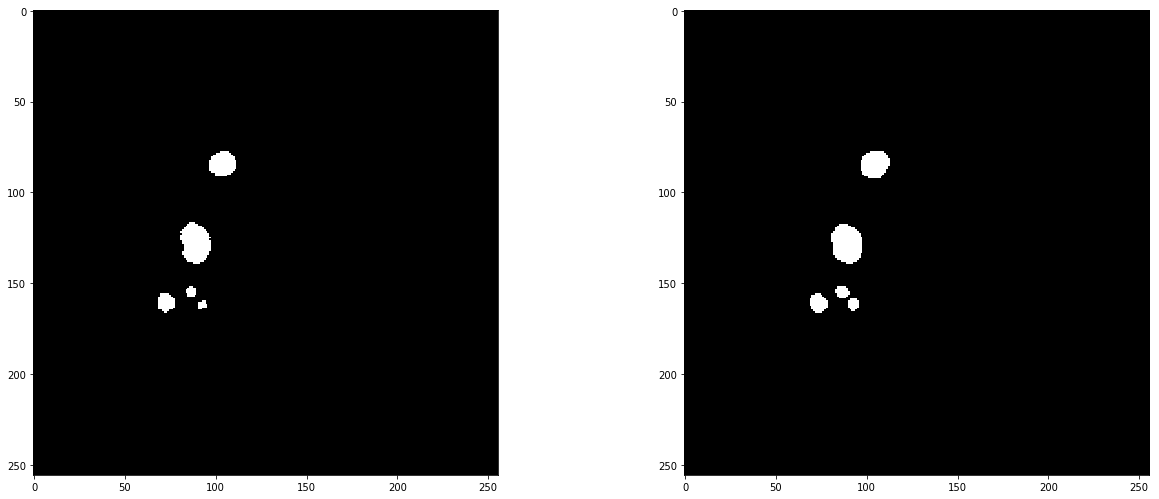

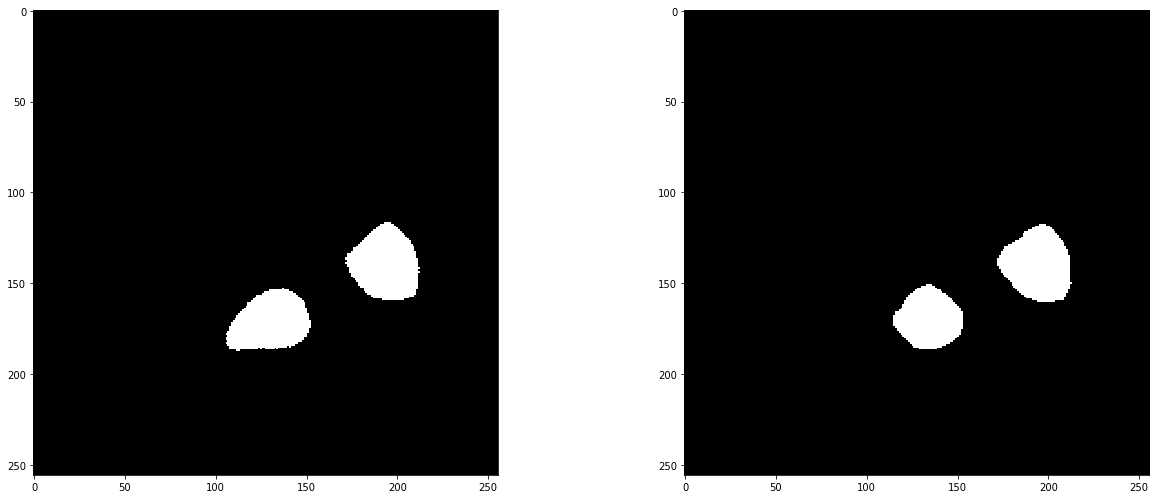

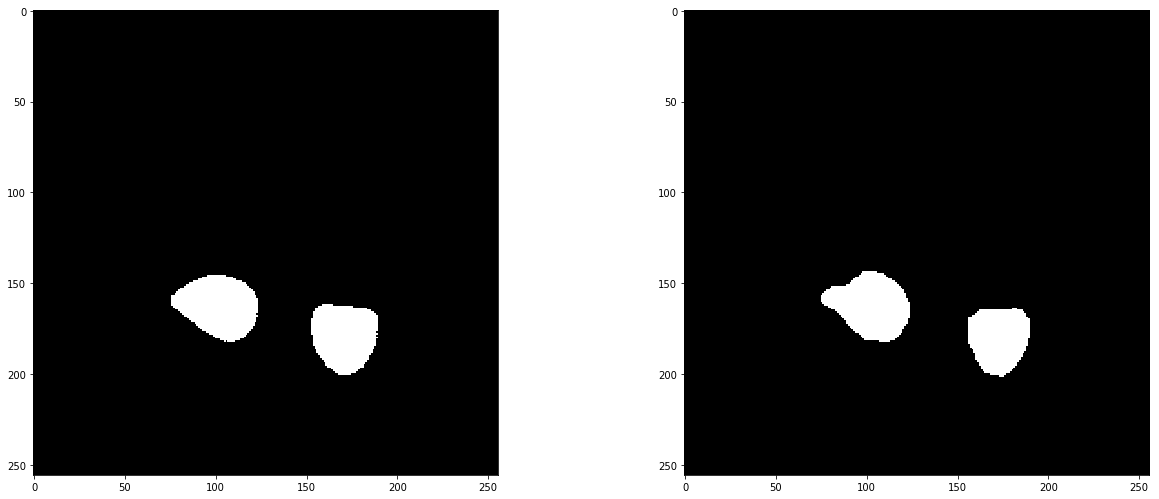

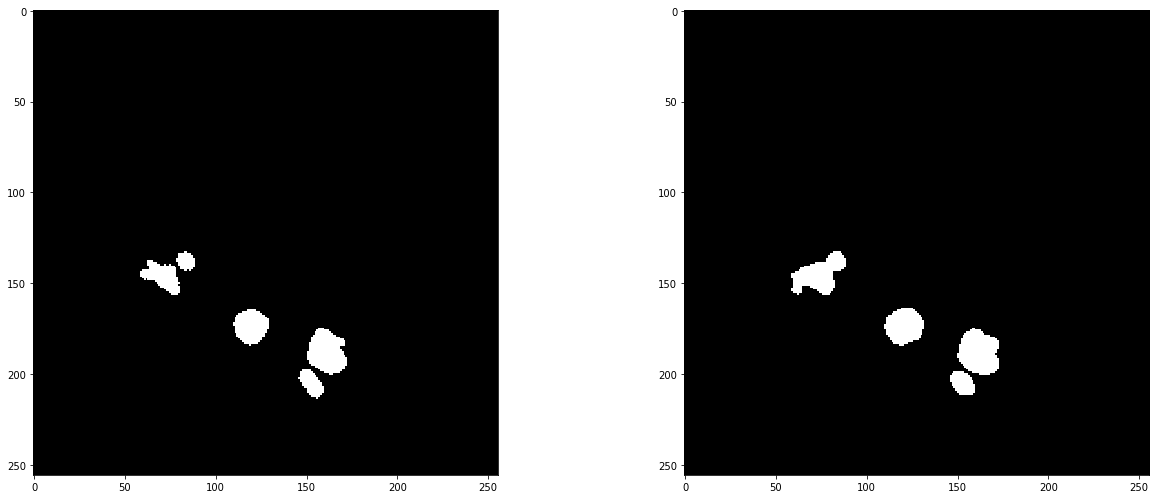

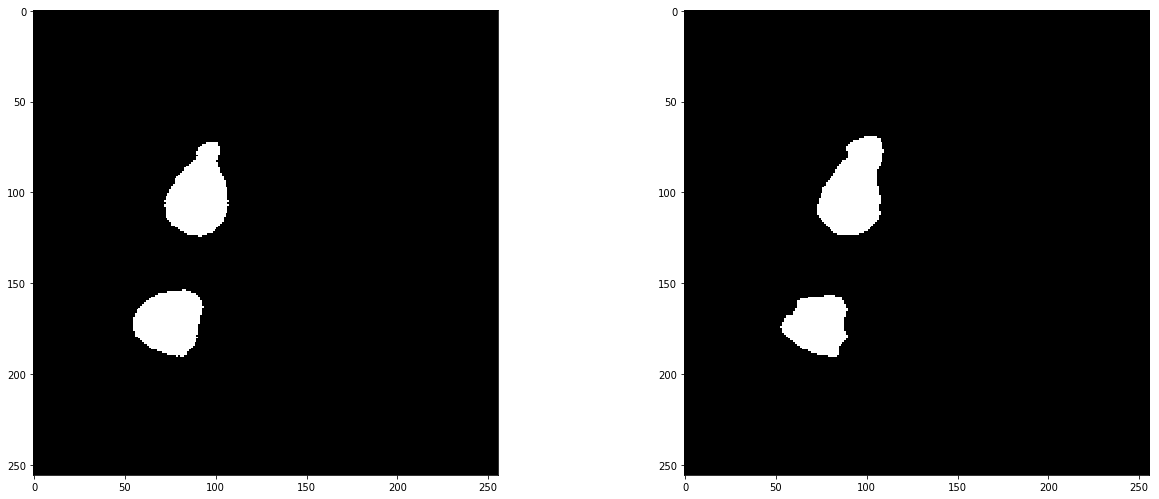

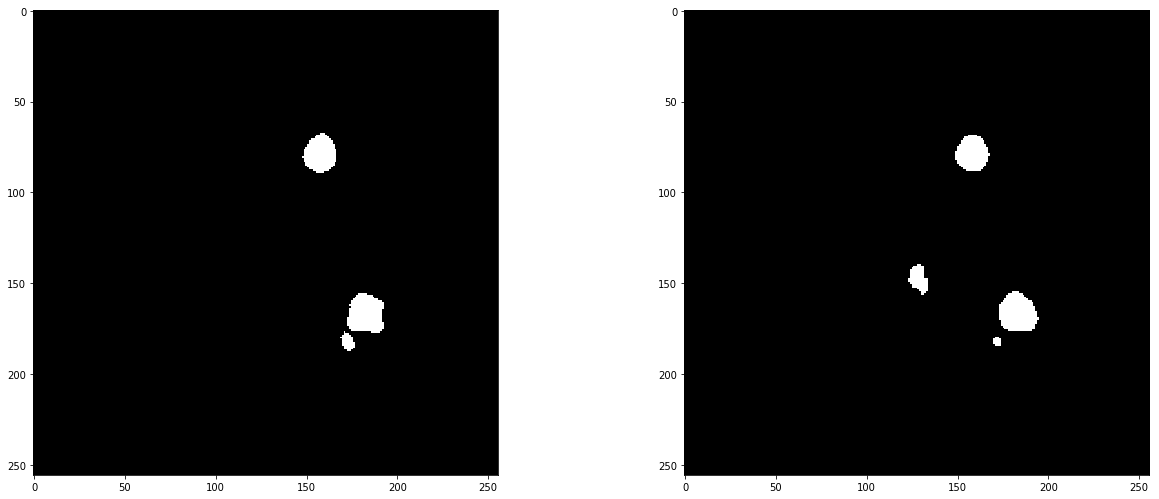

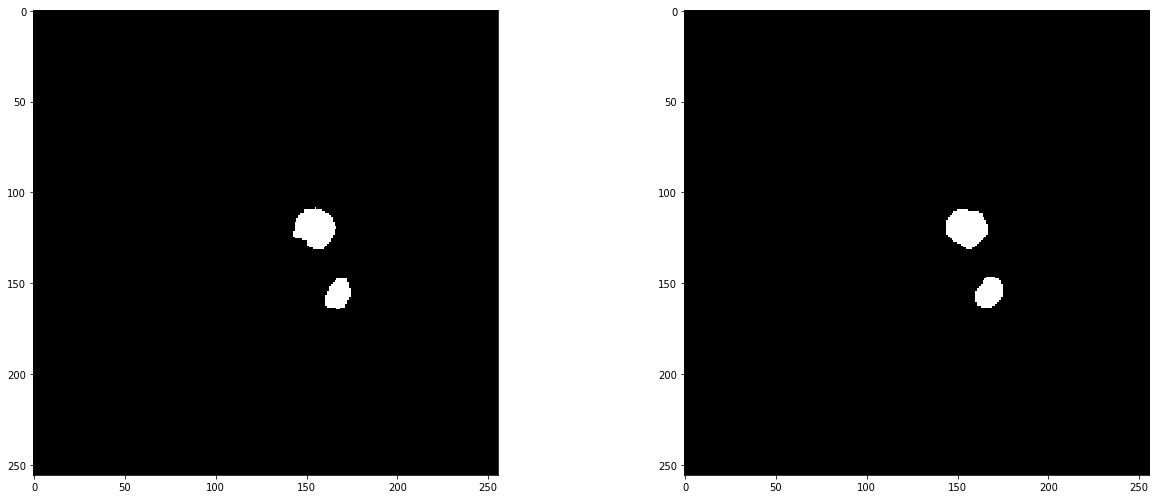

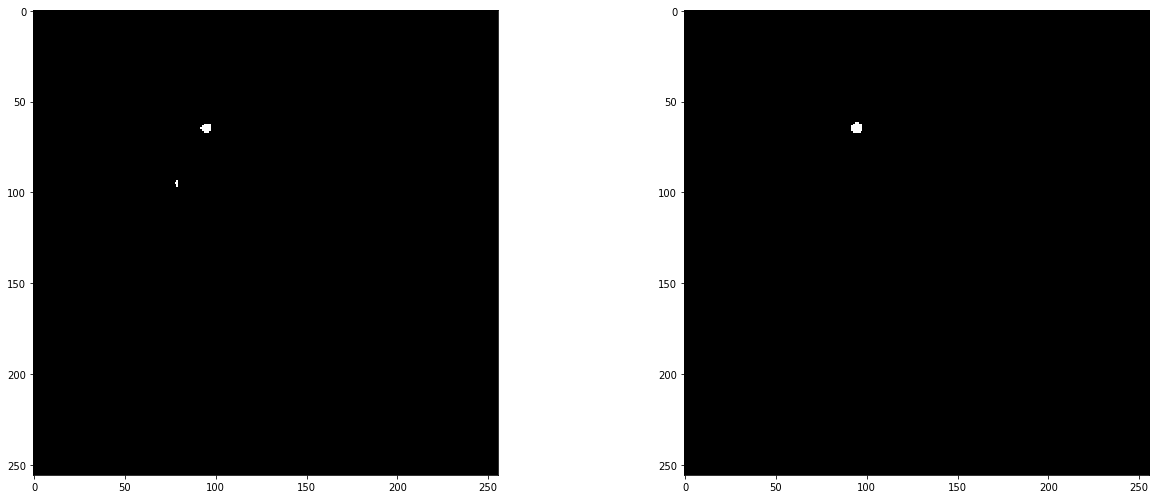

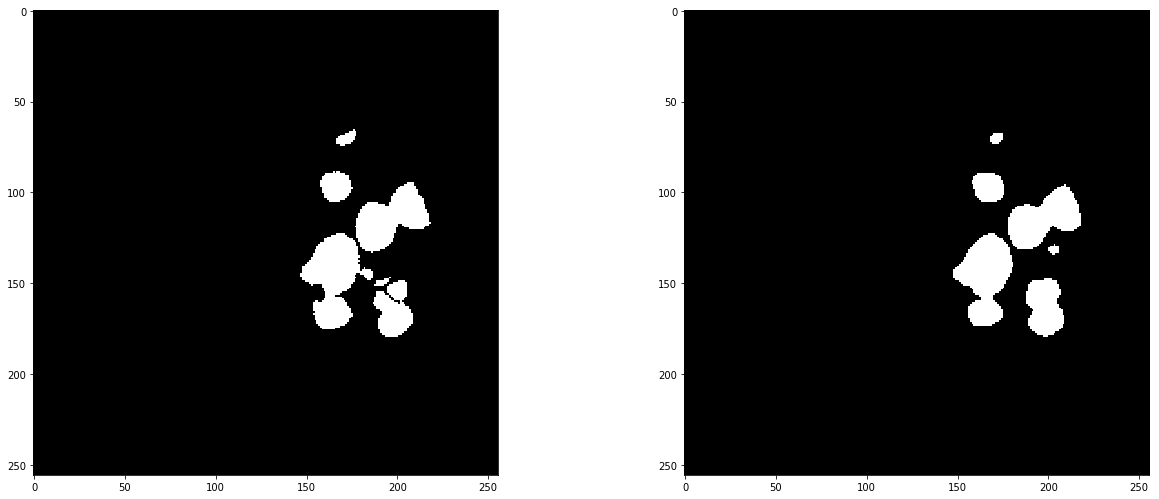

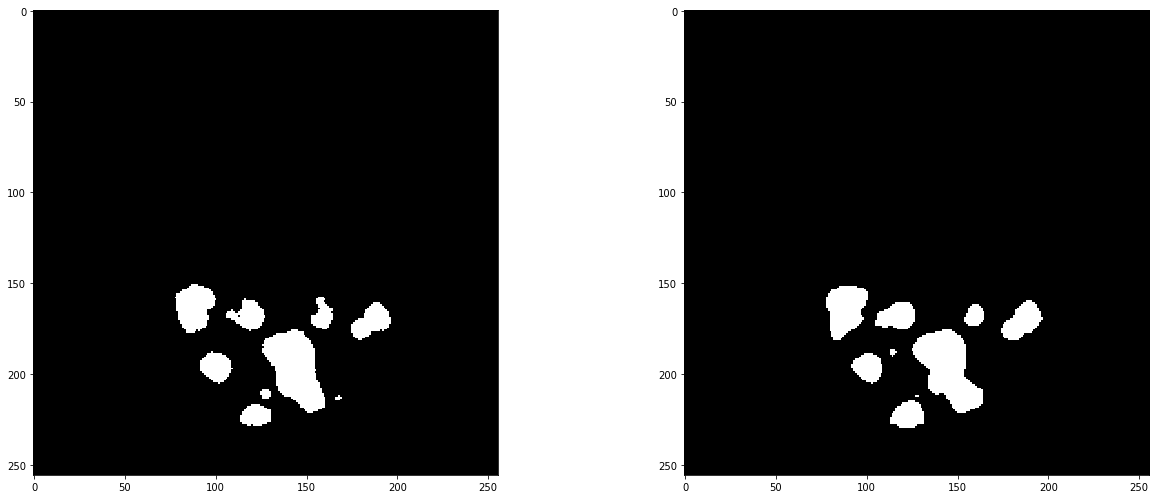

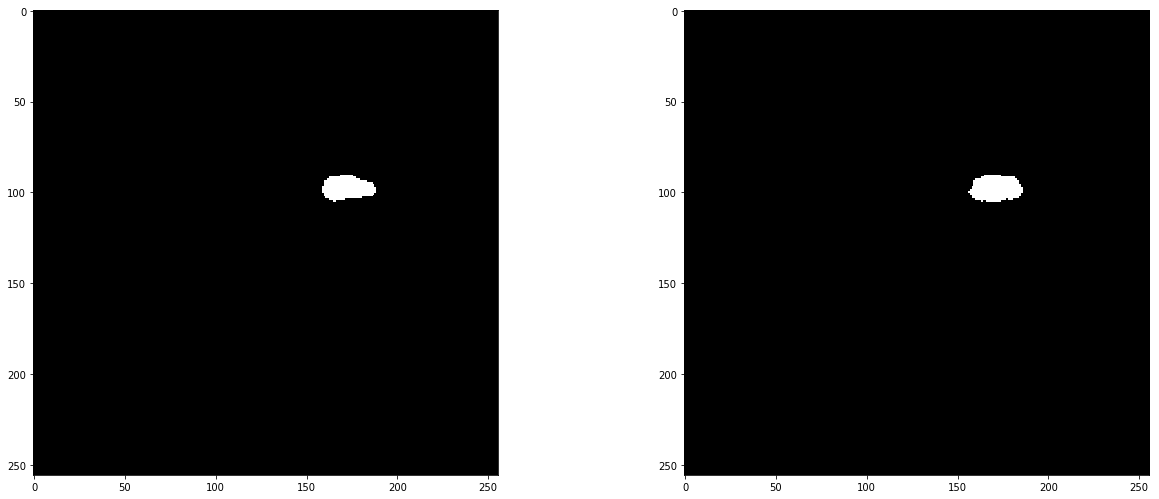

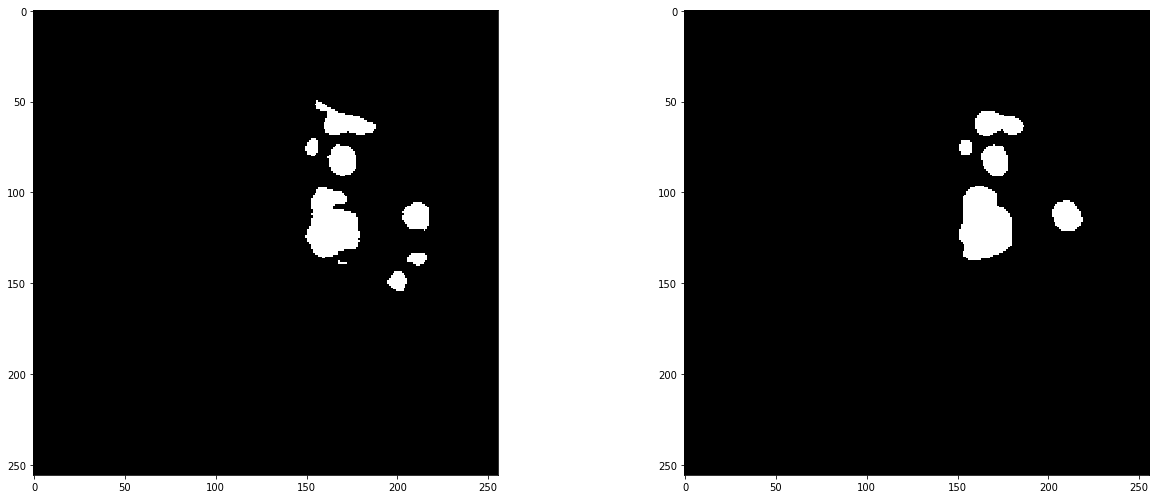

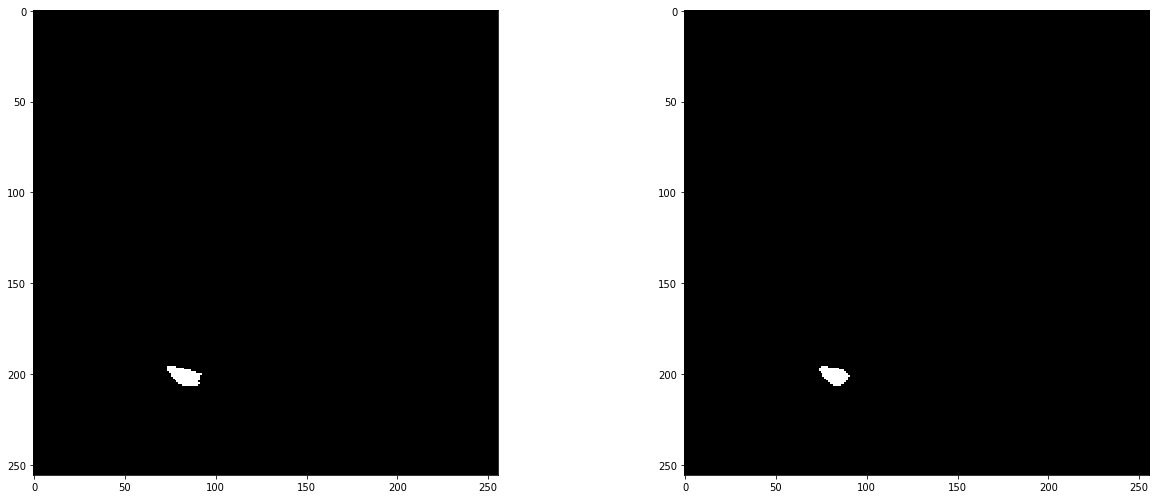

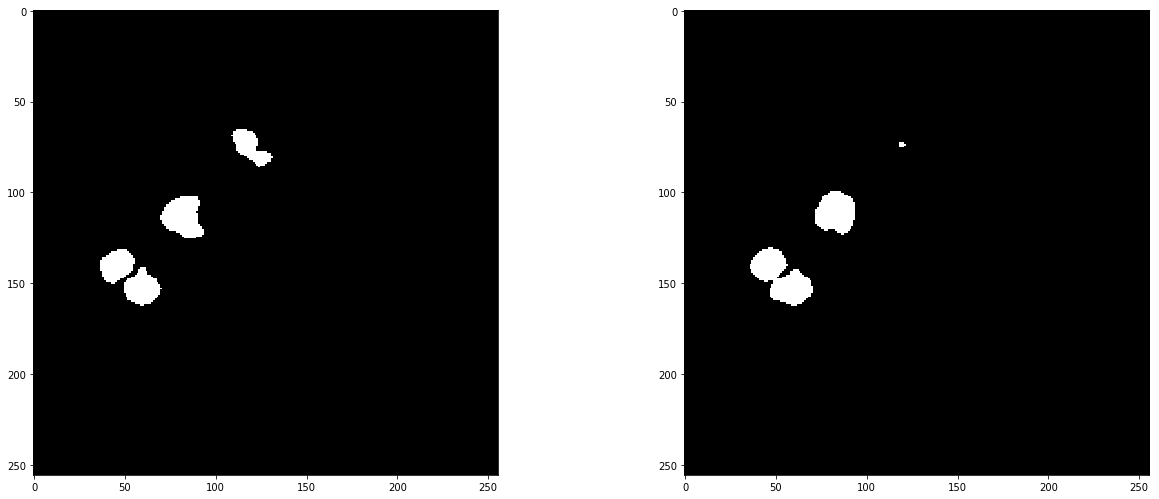

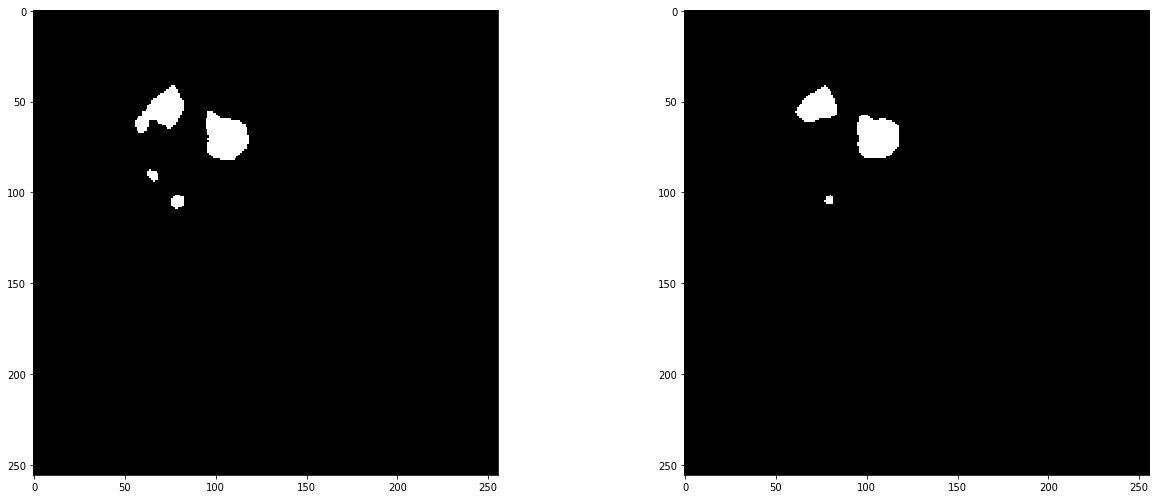

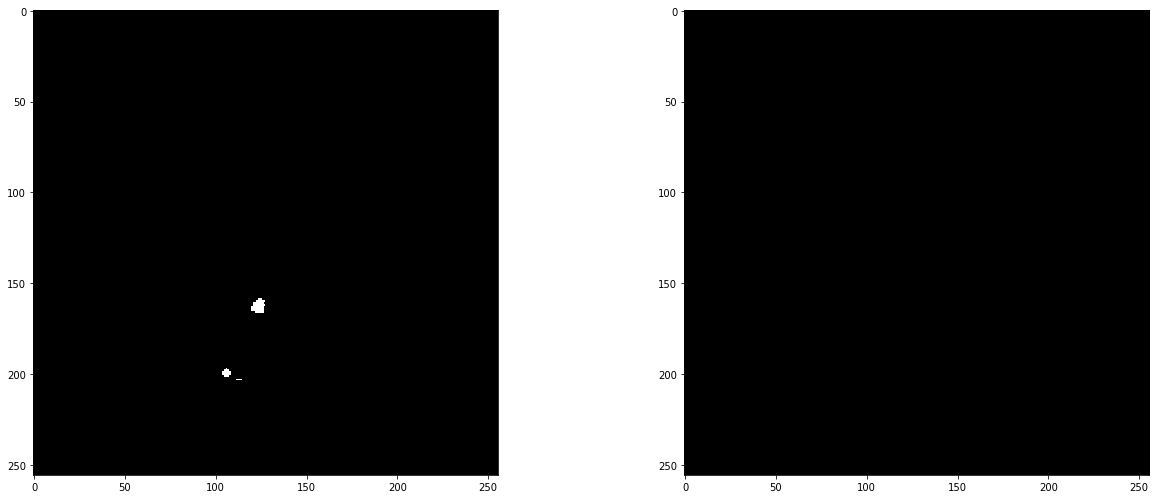

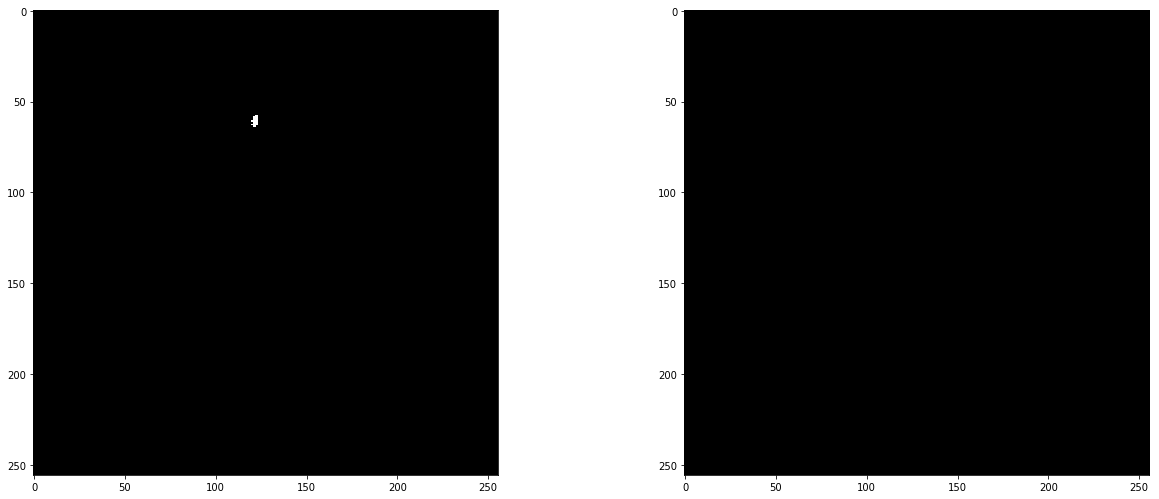

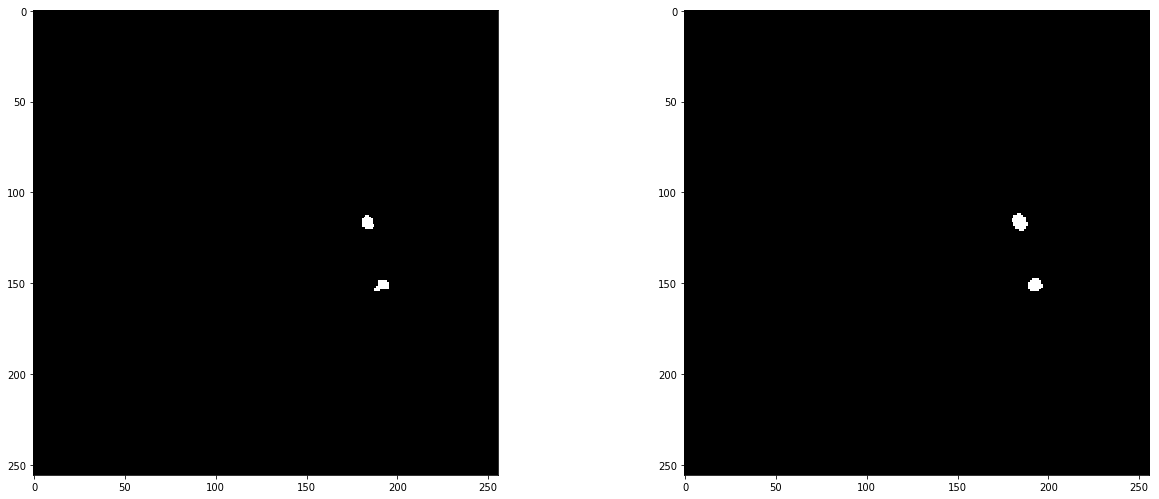

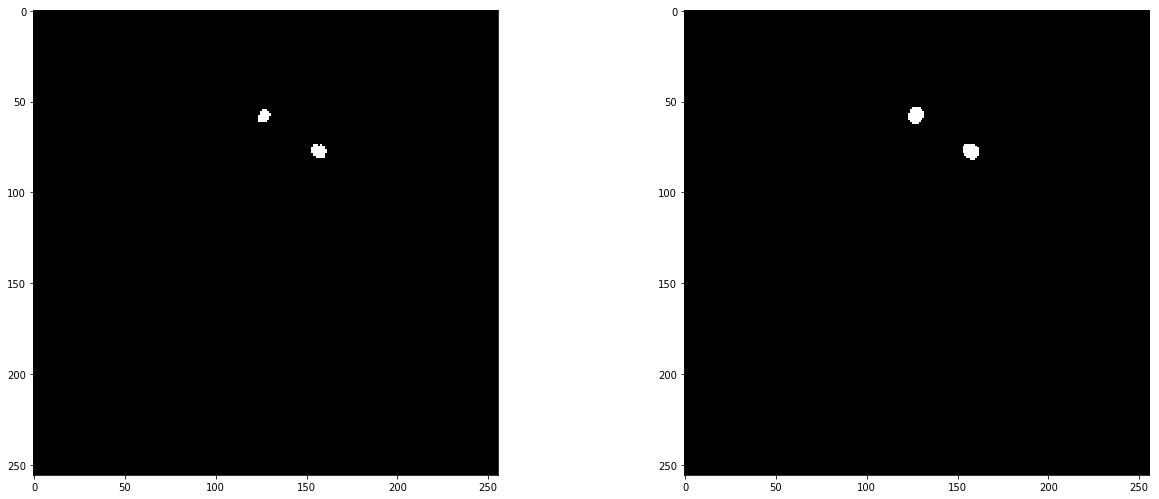

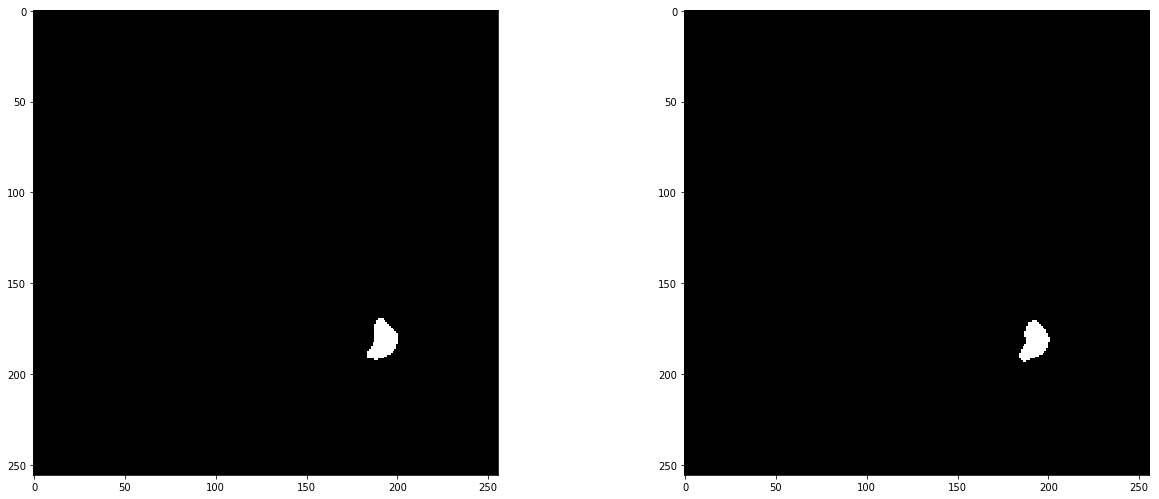

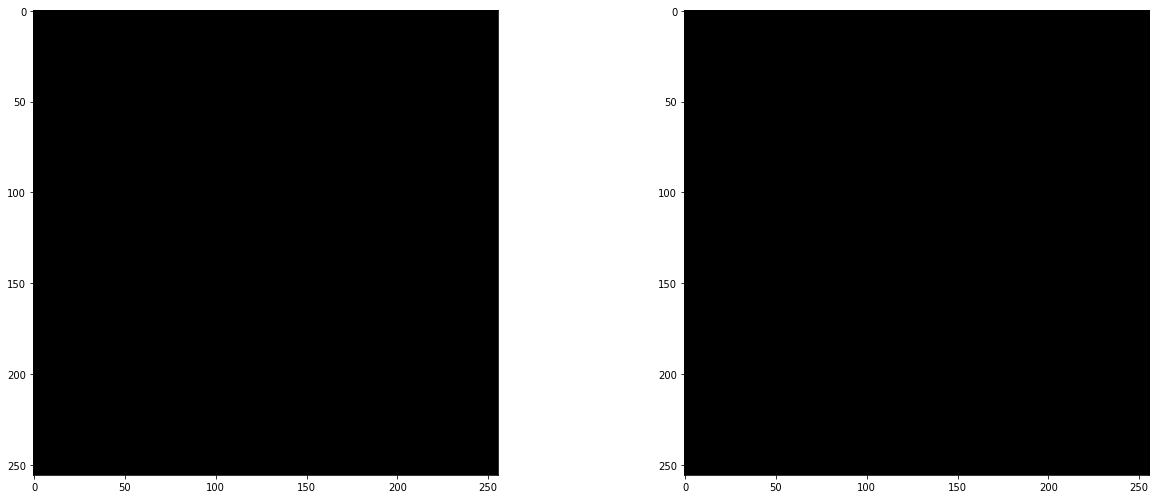

In [15]:
# imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")
for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4
#     print(id_name)
    for j in range(len(result)):
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[j]*255, (image_size, image_size)), cmap="gray")
#         ax.imshow(y[i])
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[j]*255, (image_size, image_size)), cmap="gray")

4
2
[[62930   216]
 [   38  2352]]
[62930   216    38  2352]


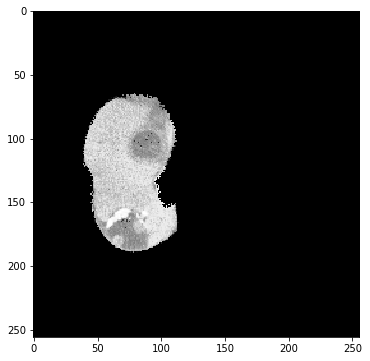

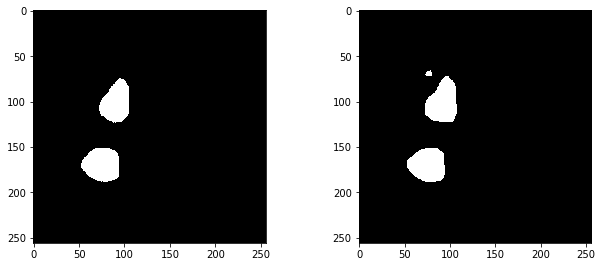

In [30]:
random_batch = random.randint(0, len(valid_ids)//batch_size - 1)
random_sample = random.randint(0, batch_size-1)
random_batch = 4
random_sample = 2
print(random_batch)
print(random_sample)
x, y = valid_gen.__getitem__(random_batch)
result =  model.predict(x)
result = result > 0

fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(1,1,1)
ax2.imshow(x[random_sample])

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
#         ax.imshow(y[i])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[random_sample]*255, (image_size, image_size)), cmap="gray")

# imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
cm_2d = confusion_matrix(y[random_sample].flatten(), result[random_sample].flatten())
cm = cm_2d.ravel()

# (tn, fp, fn, tp)
print(cm_2d)
print(cm)

In [31]:
print("Pixel Accuracy " + str(((cm[3]+cm[0])/(cm[3]+cm[0]+cm[1]+cm[2])*100))+'%' )
print("True Positive Accuracy " + str(((cm[3])/(cm[3]+cm[2])*100))+'%' )
print("Dice Coefficient " + str(dice(y[random_sample], result[random_sample])))


Pixel Accuracy 99.6124267578125%
True Positive Accuracy 98.41004184100419%
Dice Coefficient 0.9487696651875757


21


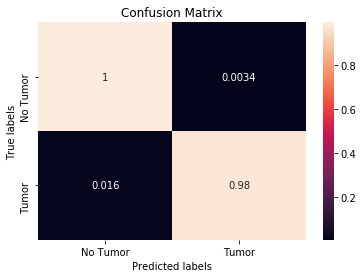

In [32]:
ax= plt.subplot()
cm_2d = cm_2d.astype('float') / cm_2d.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_2d, annot=True, ax = ax); #annot=True to annotate cells

print(count_cms)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Tumor', 'Tumor']); ax.yaxis.set_ticklabels(['No Tumor', 'Tumor']);

